<a href="https://colab.research.google.com/github/yeesem/Advanced-Tensorflow-Specialization/blob/main/Saliency_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Build the Model

In [4]:
# Get the model from tensorflow hub and append a softmax activation
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/classification/4"),
    tf.keras.layers.Activation('softmax')
])

# Build the model based on a specified batch input shape
model.build([None,300,300,3])

# Get a Sample Image

In [5]:
!wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

--2024-06-02 03:50:09--  https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.40.96, 172.64.147.160, 2606:4700:4400::ac40:93a0, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.40.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 212830 (208K) [binary/octet-stream]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 207.84K  --.-KB/s    in 0.005s  

2024-06-02 03:50:09 (39.7 MB/s) - ‘image.jpg’ saved [212830/212830]



# Preprocess the Image

In [7]:
# Read the image
img = cv2.imread('image.jpg')

# Format it to be in the RGB colorspace
# When you read an image using cv2.imread(), OpenCV loads the image in BGR (Blue, Green, Red) format by default.
# This means that the color channels are ordered as Blue first, then Green, and finally Red.
# Many other image processing libraries, such as those used in deep learning (e.g., TensorFlow, Keras, and PIL),
# expect images to be in RGB (Red, Green, Blue) format. This is the more conventional ordering where
# the Red channel comes first, followed by Green, and then Blue.
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# Resize to 300x300 and normalize pixel values to be in the range [0,1]
img = cv2.resize(img,(300,300))/255.0

# Add a batch dimension in front
image = np.expand_dims(img,axis = 0)

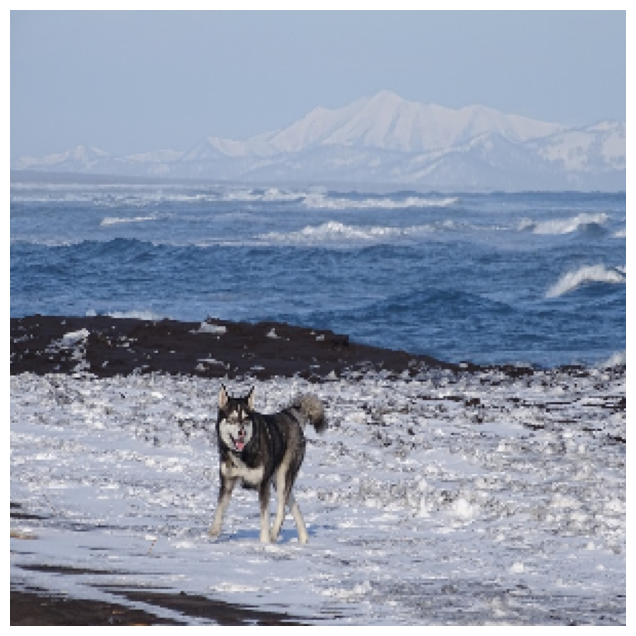

In [8]:
plt.figure(figsize = (8,8))
plt.imshow(img)
plt.axis('off')
plt.show()

# Compute Gradients

In [20]:
# Siberian Husky's class ID in ImageNet
class_index = 251

# If you downloaded the cat, use this line
# class_index = 282

# number of classed in the model's training data
num_classes = 1001

# Convert to one hot representation to match our softmax activation in the model defination
# tf.one_hot([3], 5)
# [[0, 0, 0, 1, 0]]
# [class_index] * image.shape[0] = 251
# image.shape[0] = 1 - because batch size = 1 [consist 4 dimensional]
expected_output = tf.one_hot([class_index] * image.shape[0],num_classes)

with tf.GradientTape() as tape:
  # cast image to float
  inputs = tf.cast(image,tf.float32)

  # Watch the input pixels
  # Tell GradientTape to watch inputs for gradient calculation.
  # In TensorFlow, the tape.watch(inputs) line is necessary when you want to explicitly
  # tell the GradientTape to track the gradients of a tensor that is not a tf.Variable.
  # This is important when you need to calculate gradients with respect to the inputs
  # themselves, which is a common requirement in tasks like adversarial attacks, saliency maps,
  # and other interpretability methods.
  tape.watch(inputs)

  # Generate the predictions
  predictions = model(inputs)

  # Get the loss
  loss = tf.keras.losses.categorical_crossentropy(
      expected_output,
      predictions
  )

# Get the gradient with respect to the inputs
gradients = tape.gradient(loss,inputs)

# Visualize the results

In [23]:
# Reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients),axis = -1)

# Normalize the pixel values to be in the range [0,255]
# The max value in the grayscale tensor will be pushed to 255
# The min value will be pushed to 0
# grayscale_tensor = tf.constant([0.2, 0.5, 0.8], dtype=tf.float32)
# min_val = tf.reduce_min(grayscale_tensor)  # 0.2
# max_val = tf.reduce_max(grayscale_tensor)  # 0.8
normalized_tensor = tf.cast(
    255 * (grayscale_tensor - tf.reduce_min(grayscale_tensor))/
    (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)


# Remove the channel dimension to make the tensor a 2D tensor
normalized_tensor = tf.squeeze(normalized_tensor)

In [26]:
# max and min value in the grayscale tensor
print(np.max(grayscale_tensor[0]))
print(np.min(grayscale_tensor[0]))
print()

# Coordinates of the first pixel where the max and min value are located
max_pixel = np.unravel_index(np.argmax(grayscale_tensor[0]),grayscale_tensor[0].shape)
min_pixel = np.unravel_index(np.argmin(grayscale_tensor[0]),grayscale_tensor[0].shape)
print(max_pixel)
print(min_pixel)
print()

# These coordinates should have the max(255) and min(0) value in the normalized tensor
print(normalized_tensor[min_pixel])
print(normalized_tensor[max_pixel])

1.0859649
0.0

(207, 132)
(0, 299)

tf.Tensor(0, shape=(), dtype=uint8)
tf.Tensor(255, shape=(), dtype=uint8)


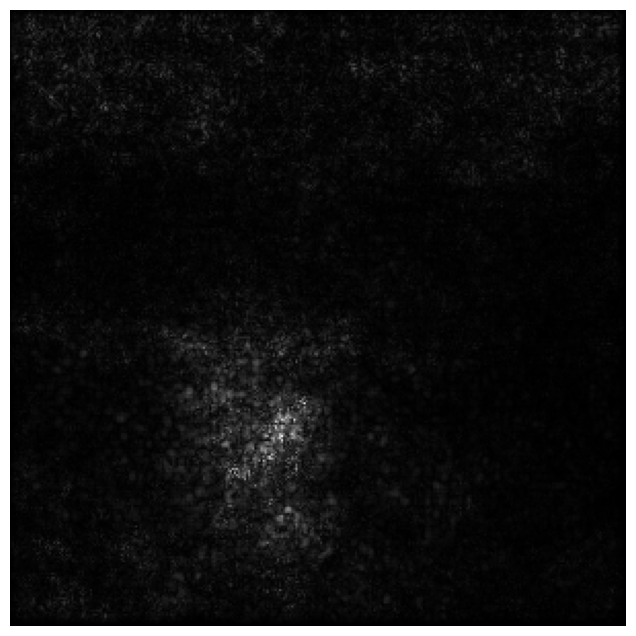

In [27]:
plt.figure(figsize = (8,8))
plt.axis('off')
plt.imshow(normalized_tensor,cmap = 'gray')
plt.show()

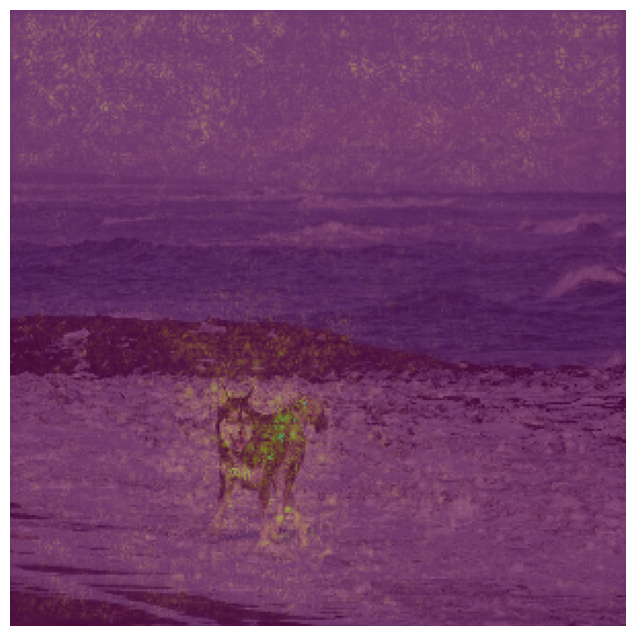

In [32]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_VIRIDIS)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img,0.3,gradient_color,0.7,0.0)

plt.figure(figsize = (8,8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()